In [12]:
import pandas_datareader as web
from datetime import date
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

In [2]:
def get_dates(data_window):
    '''
    Returns the start date and end date for given number of years

    Parameters:
    data_window (int): number of years of past data

    Returns:
    start_date (datetime): start date
    end_date (datetime): today's date
    '''
    end_date = pd.to_datetime(date.today())
    start_date = pd.to_datetime(
        date.today() + relativedelta(years=-data_window))

    return start_date, end_date

In [3]:
# take a look at SPY
data_window = 1  # number of years of historical data to look at
start_date, end_date = get_dates(data_window)
stock = 'SPY'  # stock symbol

df = web.DataReader(stock, data_source='yahoo',
                    start=start_date, end=end_date)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-12,266.660004,247.679993,256.000000,248.110001,392220700.0,243.561539
2020-03-13,271.480011,248.520004,263.089996,269.320007,329566100.0,264.382690
2020-03-16,256.899994,237.360001,241.179993,239.850006,297240000.0,235.452972
2020-03-17,256.170013,237.070007,245.039993,252.800003,262070500.0,248.165558
2020-03-18,248.369995,228.020004,236.250000,240.000000,327597100.0,235.600204
...,...,...,...,...,...,...
2021-03-08,387.679993,381.420013,384.660004,381.720001,122957100.0,381.720001
2021-03-09,389.910004,385.309998,385.850006,387.170013,113457800.0,387.170013
2021-03-10,391.399994,388.170013,389.690002,389.579987,109660800.0,389.579987


In [4]:
# check for null values
df.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

Text(0.5, 1.0, 'SPY')

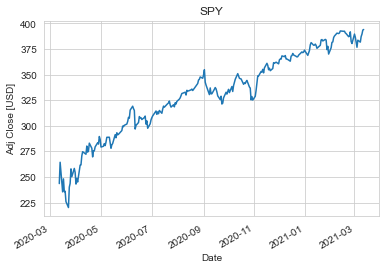

In [5]:
# plot adjusted close
sns.set_style('whitegrid')
df['Adj Close'].plot()
plt.xlabel('Date')
plt.ylabel('Adj Close [USD]')
plt.title('SPY')

In [6]:
future_days = 28  # number of days lookahead for future value
# add target data as 30 day price prediction
df['Future'] = df['Adj Close'].shift(-future_days)

In [7]:
# take a look at the dataframe now
df

,High,Low,Open,Close,Volume,Adj Close,Future
Date,,,,,,,
2020-03-12,266.660004,247.679993,256.000000,248.110001,392220700.0,243.561539,275.594513
2020-03-13,271.480011,248.520004,263.089996,269.320007,329566100.0,264.382690,275.574738
2020-03-16,256.899994,237.360001,241.179993,239.850006,297240000.0,235.452972,279.415924
2020-03-17,256.170013,237.070007,245.039993,252.800003,262070500.0,248.165558,283.444672
2020-03-18,248.369995,228.020004,236.250000,240.000000,327597100.0,235.600204,282.141235
...,...,...,...,...,...,...,...
2021-03-08,387.679993,381.420013,384.660004,381.720001,122957100.0,381.720001,NaN
2021-03-09,389.910004,385.309998,385.850006,387.170013,113457800.0,387.170013,NaN
2021-03-10,391.399994,388.170013,389.690002,389.579987,109660800.0,389.579987,NaN


In [8]:
# define features and labels
X = df[['Adj Close']].iloc[:-future_days]
y = df['Future'].iloc[:-future_days]

In [9]:
# split data into train and test sets
X_train = X.iloc[:-future_days]
y_train = y.iloc[:-future_days]
X_test = X.iloc[-future_days:]
y_test = y.iloc[-future_days:]

In [10]:
def plot_prediction(model, last_n_days=180):
    '''
    Plots actual and predicted stock price using a given machine learning model. 
    Provides evaluation metrics as well.

    Parameters:
    model: machine learning model
    last_n_days (int): last number of days to plot

    Returns:
    None
    '''

    model.fit(X_train, y_train)  # train model
    y_pred = model.predict(X_test)  # make predictions on test dataset
    # store the adjusted close results in a dataframe
    results = pd.DataFrame(
        {'Actual': df['Adj Close'].iloc[-future_days:], 'Predicted': y_pred})

    # print evaluation metrics
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(
        metrics.mean_squared_error(y_test, y_pred)))
    print('R2 Score:', metrics.r2_score(y_test, y_pred))

    # plot data
    df['Adj Close'].iloc[-last_n_days:].plot(label='Actual')
    results['Predicted'].plot(label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Adj Close [USD]')
    plt.title('SPY')

### Use decision tree

Mean Absolute Error: 16.05499267578125
Mean Squared Error: 290.0482102130939
Root Mean Squared Error: 17.03080180769813
R2 Score: -13.00136013181167


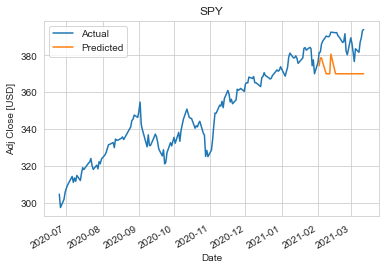

In [13]:
plot_prediction(DecisionTreeRegressor())

### Use linear regression

Mean Absolute Error: 9.100415867455638
Mean Squared Error: 108.09473185661044
Root Mean Squared Error: 10.39686163496516
R2 Score: -4.218005889310929


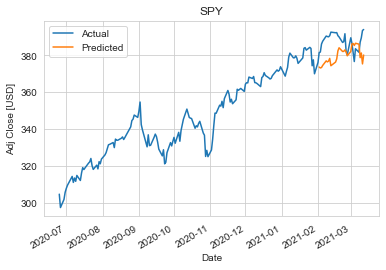

In [14]:
plot_prediction(LinearRegression())

### Use KNN

Mean Absolute Error: 10.584060886928016
Mean Squared Error: 133.8517057299761
Root Mean Squared Error: 11.569429792776138
R2 Score: -5.461360112533701


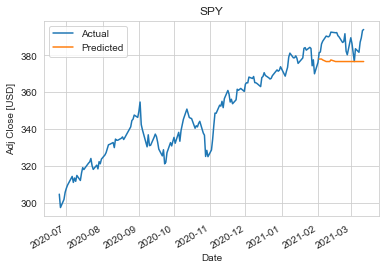

In [15]:
plot_prediction(KNeighborsRegressor())